Binome: Sihamdi Mostefa,Benaskeur moussabe

# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [1]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int(3*sigma)
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()


## Exercice 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [2]:
import math  
def SobelDetector(I, s):
    """ Array*double -> Array """
    Sx=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sy=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    Gx=convolve2d(I,Sx,mode='same')
    Gy=convolve2d(I,Sy,mode='same')
    norme=np.sqrt(Gx**2+Gy**2)
    return np.where((norme<s),0,1) 
    
    


2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [3]:
def LaplacianDetector(I, s):
    """ Array*double -> Array """
    L=np.array([[0,1,0],[1,-4,1],[0,1,0]])
    g=convolve2d(I,L)
    result=np.zeros((g.shape[0],g.shape[1]))
    for x in range(1,g.shape[0]):
        for y in range(1,g.shape[1]):
            neigbourg = g[x-1:x+2,y-1:y+2]
            if(np.min(neigbourg) < 0 and np.max(neigbourg) > 0 and np.max(neigbourg) - np.min(neigbourg) > s):
                result[x][y] = 1
    return result
                
    
    
    


3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

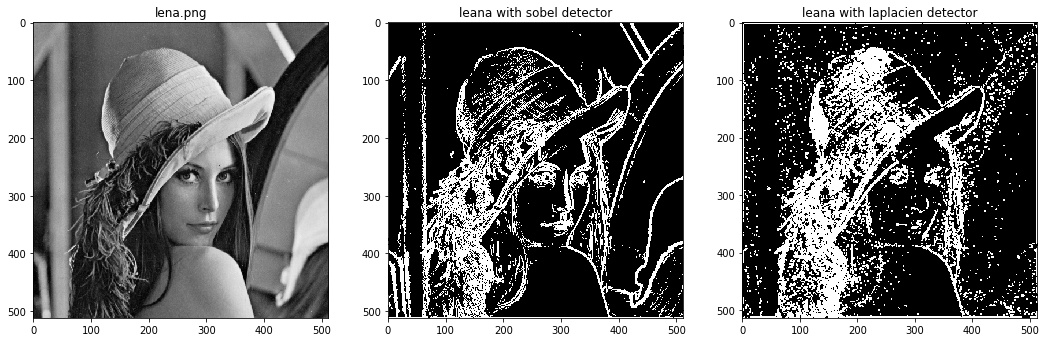

In [9]:
leana = np.array(Image.open("img/lena.png"))
lena_with_sobel=SobelDetector(leana,70)
lena_with_laplacian=LaplacianDetector(leana,70)
result=[]
titel=[]
result.append(leana)
titel.append("lena.png")
result.append(lena_with_sobel)
titel.append("leana with sobel detector")
result.append(lena_with_laplacian)
titel.append("leana with laplacien detector")

niceDisplay14(result,titel)

## Exercice 2: Non maximum suppression

This exercice addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the nootebook to see pixels value pointed by the mouse screen).

<IPython.core.display.Javascript object>


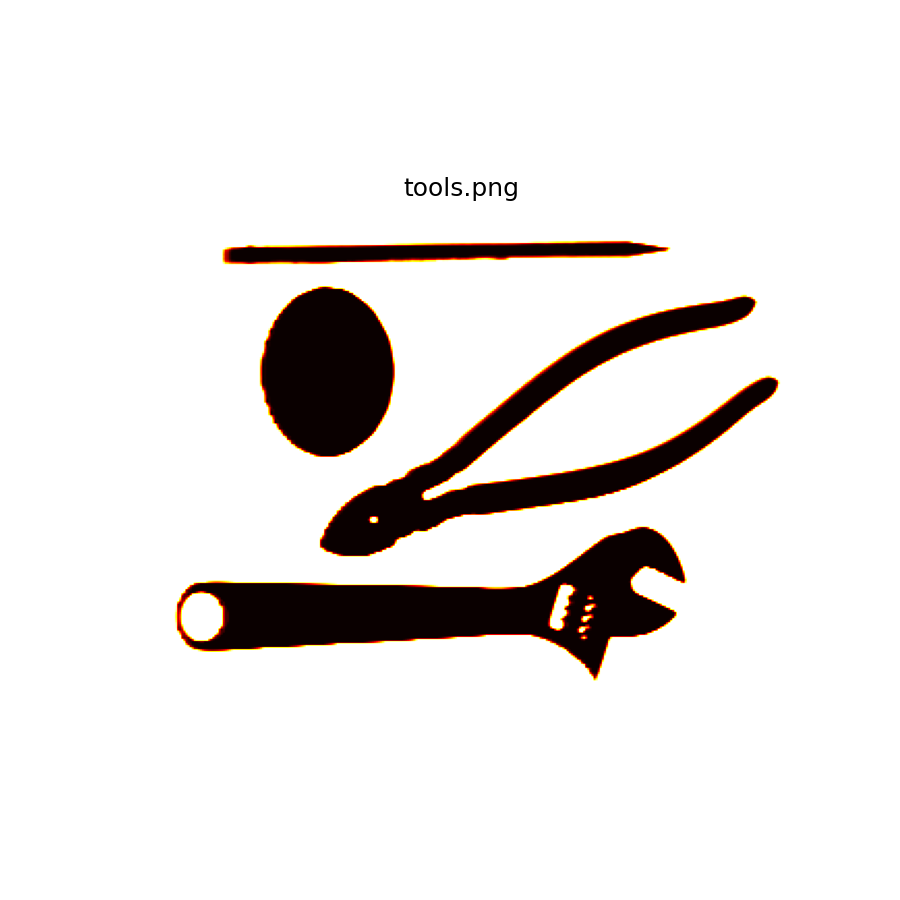

[[4. 3. 3. ... 3. 3. 2.]
 [1. 0. 0. ... 0. 0. 4.]
 [1. 0. 0. ... 0. 0. 4.]
 ...
 [1. 0. 0. ... 0. 0. 4.]
 [1. 0. 0. ... 0. 0. 4.]
 [2. 3. 3. ... 3. 3. 4.]]


<IPython.core.display.Javascript object>


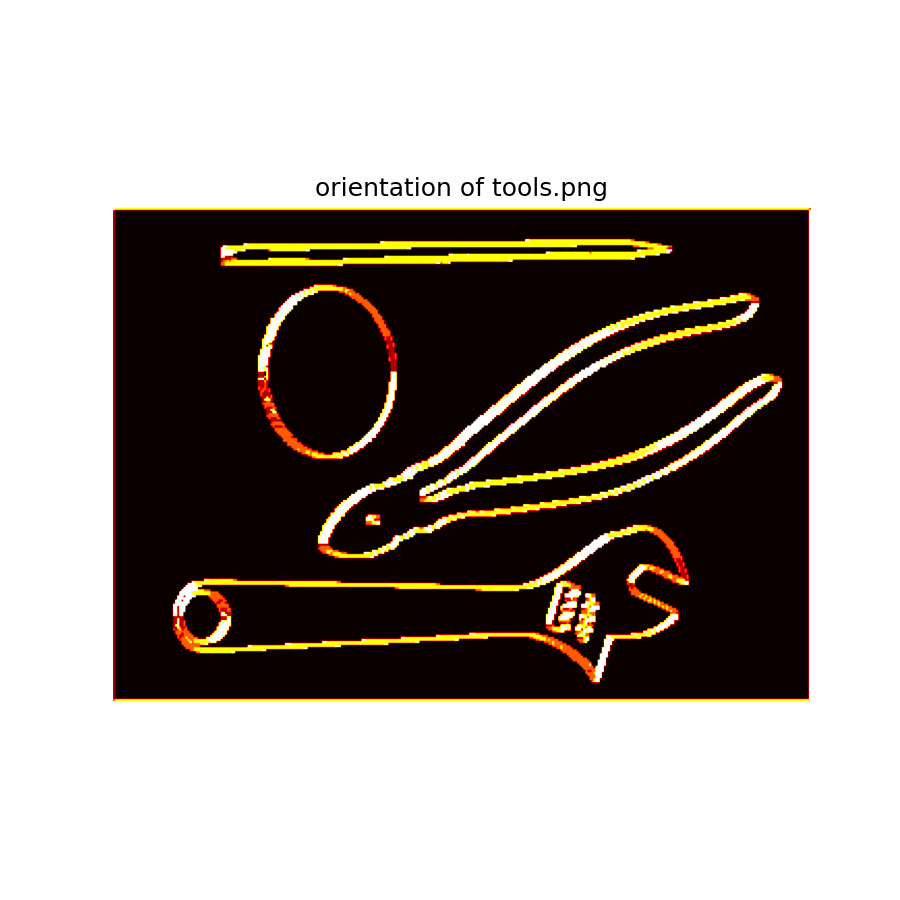

In [4]:
%matplotlib notebook
#### your answer below
Sx=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
Sy=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
tools = np.array(Image.open("img/tools.png"))
imshow_hot(tools,"tools.png")
Gx=convolve2d(tools,Sx,mode='same')
Gy=convolve2d(tools,Sy,mode='same')
norm=np.sqrt(Gx**2+Gy**2)
Ior=orientation(Gx,Gy,norm)
print(Ior)
imshow_hot(Ior,"orientation of tools.png")


Explain the different values given to a pixel by `orientation()`:

Your answer: 

The values given by orientation correspond to the direction of the gradient, i.e. the direction in which the contrast is maximum. For example the value associated with the color yellow in the image above corresponds to the gradients having a vertical orientation.

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [7]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    result=np.zeros((Ig.shape[0],Ig.shape[1]))
    for i in range(1,Ig.shape[0]-1):
        for j in range(1,Ig.shape[1]-1):
            if Ior[i,j] == 0: continue
            if Ior[i,j] == 1: 
                r = Ig[i,j+1]
                q = Ig[i,j-1]
            if Ior[i,j] == 2: 
                r = Ig[i+1,j-1]
                q = Ig[i-1,j+1]
            if Ior[i,j] == 3: 
                r = Ig[i+1,j]
                q = Ig[i-1,j]
            if Ior[i,j] == 4: 
                r = Ig[i-1,j-1]
                q = Ig[i+1,j+1]
            if(Ig[i,j]>r and Ig[i,j]>q):
                result[i,j]=Ig[i,j]
    return result

    


3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


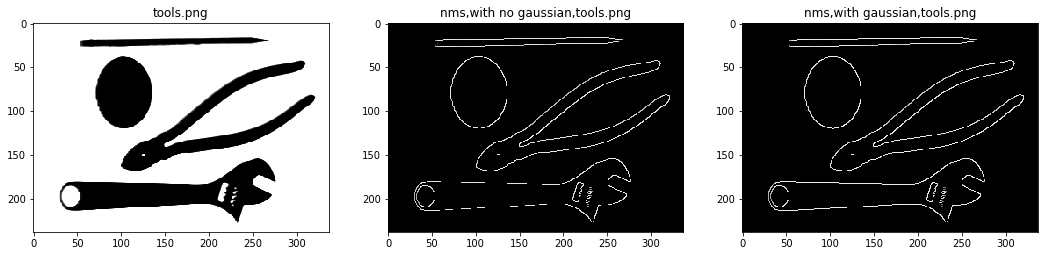

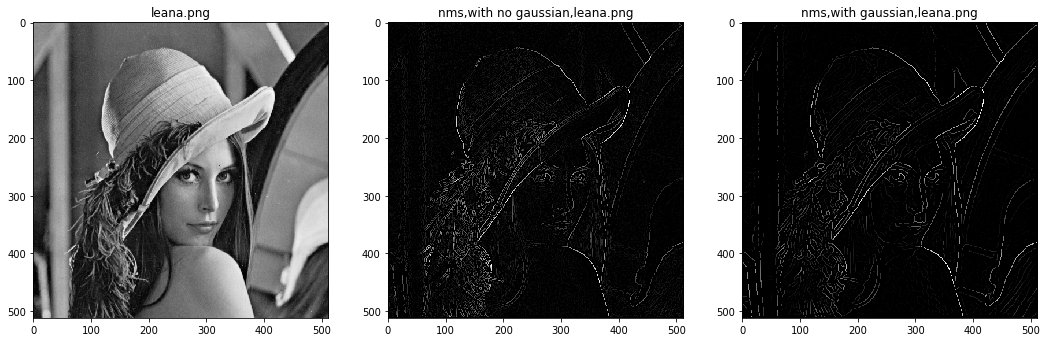

In [10]:
%matplotlib inline
### your answer below
def applique_nms(image):
    Sx=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sy=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    Gx=convolve2d(image,Sx,mode='same')
    Gy=convolve2d(image,Sy,mode='same')
    norme=np.sqrt(Gx**2+Gy**2)
    return nms(norme,orientation(Gx,Gy,norme))


def gaussien_nms(image, sigma):
    Sx=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sy=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    filtred_image=convolve2d(image,gaussianKernel(sigma),'same')
    Gx=convolve2d(filtred_image,Sx,mode='same')
    Gy=convolve2d(filtred_image,Sy,mode='same')
    norme=np.sqrt(Gx**2+Gy**2)
    return nms(norme,orientation(Gx,Gy,norme))
result=[]
title=[]
result1=[]
title1=[]

result.append(tools)
title.append("tools.png")
result.append(applique_nms(tools))
title.append("nms,with no gaussian,tools.png")
result.append(gaussien_nms(tools,0.5))
title.append("nms,with gaussian,tools.png")
niceDisplay14(result,title)

result1.append(leana)
title1.append("leana.png")
result1.append(applique_nms(leana))
title1.append("nms,with no gaussian,leana.png")
result1.append(gaussien_nms(leana,2))
title1.append("nms,with gaussian,leana.png")

niceDisplay14(result1,title1)



4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

In [11]:
import ipywidgets as widgets
from ipywidgets import interact
interact(lambda a: imshow(gaussien_nms(tools,a),"tools.png, with different sigma values"), a=widgets.FloatSlider(min=0.1, max=3, step=0.2, value=1.2))

interactive(children=(FloatSlider(value=1.2, description='a', max=3.0, min=0.1, step=0.2), Output()), _dom_cla…

<function __main__.<lambda>(a)>

.The smoothing attenuates the contrasts, so we can see that the contours disappearing in certain places. The contours are less thick.

.When  𝜎  gets bigger we get rid of more and more noise and thus we keep only the real and important edges in the image



## Exercice 3:  Effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

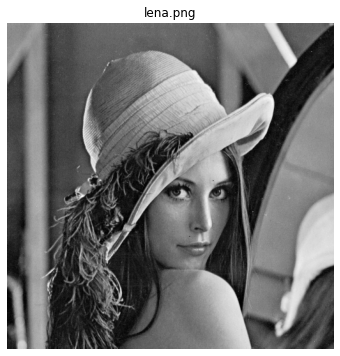

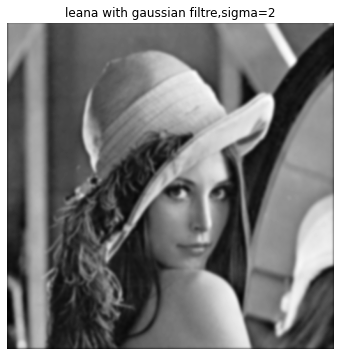

In [13]:
leana_filtred=convolve2d(leana,gaussianKernel(2),'same')
imshow(leana,"lena.png")
imshow(leana_filtred,"leana with gaussian filtre,sigma=2")

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

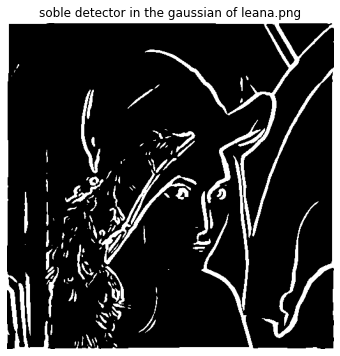

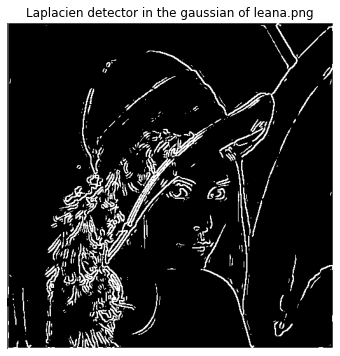

In [96]:
imshow(SobelDetector(leana_filtred,80),"soble detector in the gaussian of leana.png")

imshow(LaplacianDetector(leana_filtred,5),"Laplacien detector in the gaussian of leana.png")

The sobel mask gives rather thick but continuous contours. Whereas the Laplacian gives finer contours but sensitive to noise and less continuous in some places.

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

In [12]:
interact(lambda sigma: imshow(SobelDetector(convolve2d(leana,gaussianKernel(sigma)),70),"sobel detector"), sigma=widgets.FloatSlider(min=0.1, max=2, step=0.1, value=0.5))

interact(lambda sigma: imshow(LaplacianDetector(convolve2d(leana,gaussianKernel(sigma)),10),"laplacien detector"), sigma=widgets.FloatSlider(min=0.1, max=2, step=0.1, value=1.6))

interactive(children=(FloatSlider(value=0.5, description='sigma', max=2.0, min=0.1), Output()), _dom_classes=(…

interactive(children=(FloatSlider(value=1.6, description='sigma', max=2.0, min=0.1), Output()), _dom_classes=(…

<function __main__.<lambda>(sigma)>

The blurring allows to have the noise disappear in a very effective way. But it prevents to locate precisely the contour, indeed with the sobel mask, the contour becomes rather thick. With the laplacian, the contour is duplicated in certain places.

4. Replace the gaussian filter by a constrast enhancer filter. Discuss the results

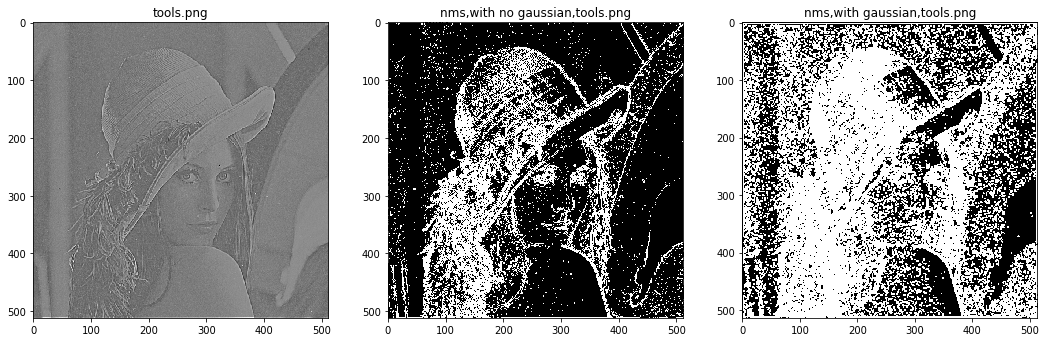

In [61]:
### filre_pass_haut=np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
leana_filtred=convolve2d(leana,filre_pass_haut,'same')
result=[]
titel=[]
result.append(leana_filtred)
titel.append("leana with constrast enhancer filter")
result.append(SobelDetector(leana_filtred,280))
titel.append("sobel detector on the filtred image")
result.append(LaplacianDetector(leana_filtred,430))
titel.append("sobel detector on the filtred image")

niceDisplay14(result,title)

The contrast enhancer filter allows to have very fine contours (which helps to locate it precisely) but with a lot of noise, especially with the Laplacian filter.

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

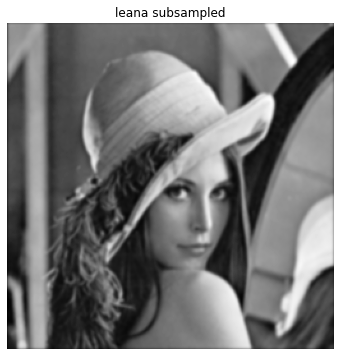

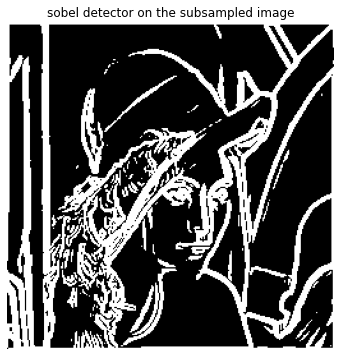

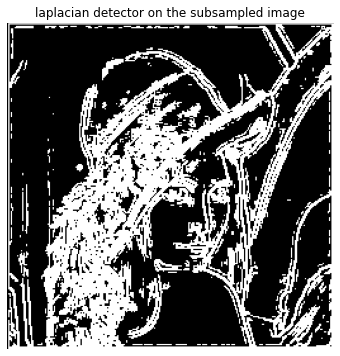

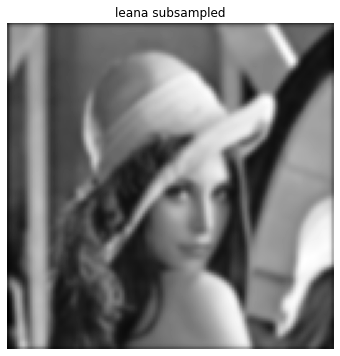

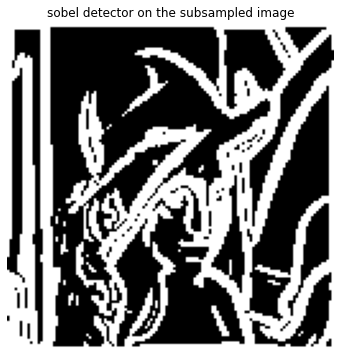

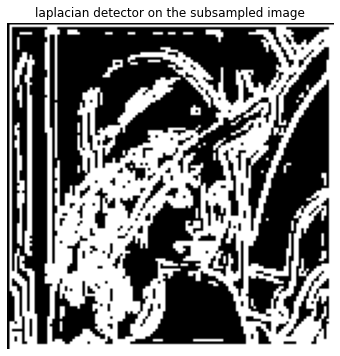

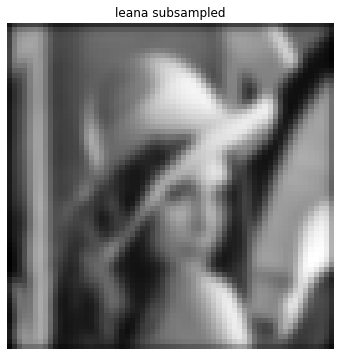

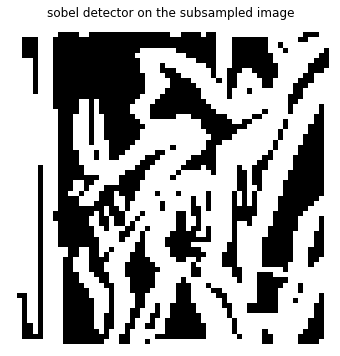

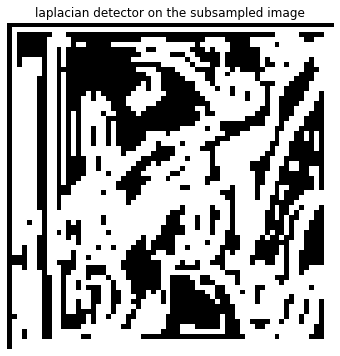

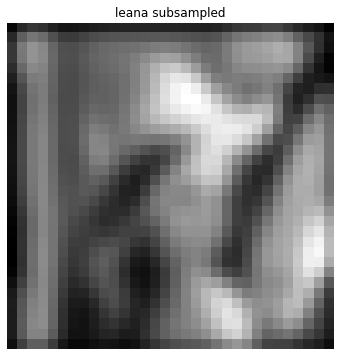

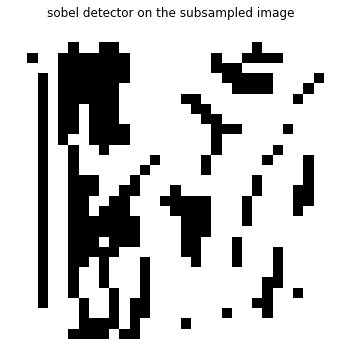

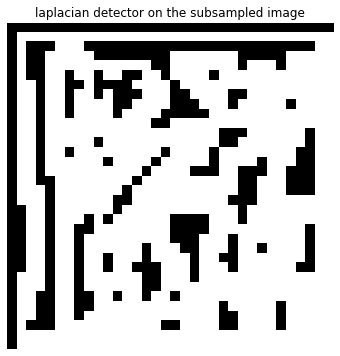

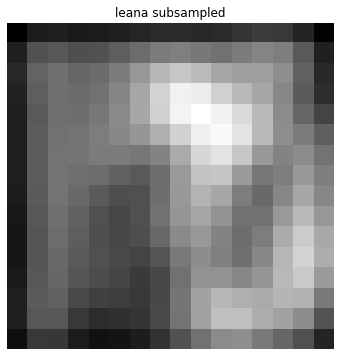

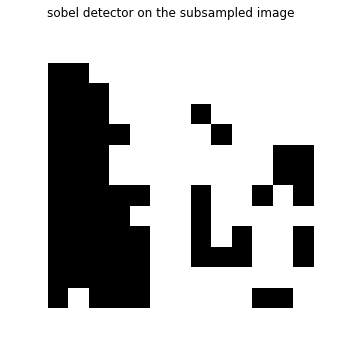

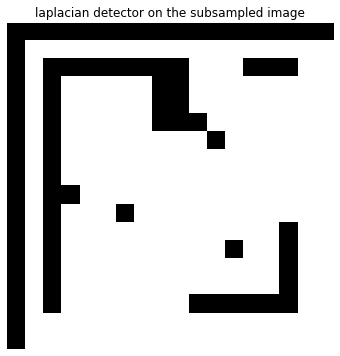

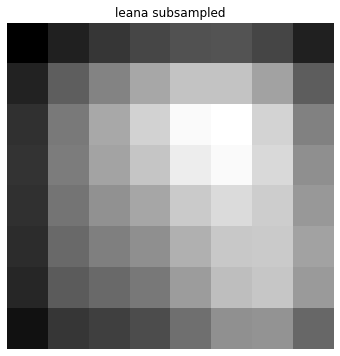

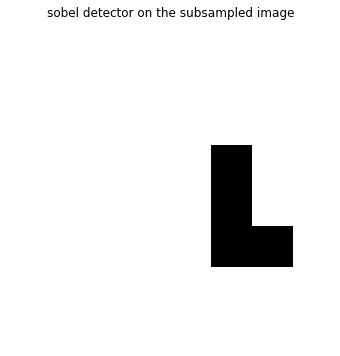

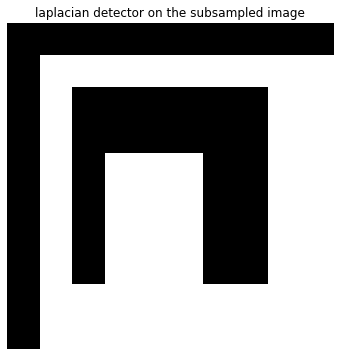

In [14]:
def subSample2(I):
    """ Array -> Array """
    return I[::2,::2]

I=leana
for i in range (6):
    I=convolve2d(I,gaussianKernel(2),'same')
    I=subSample2(I)
    imshow(I,"leana subsampled")
    imshow(SobelDetector(I,70),"sobel detector on the subsampled image")
    imshow(LaplacianDetector(I,10),"laplacian detector on the subsampled image")

this operation allows to have rather thick contours without too much noise, allowing to see the "general" shape of the objects. But after a few iterations the image becomes well pixelated so that we can get several precise information from it. 